In [94]:
import requests
import bs4
import re
import pandas as pd
import json
import numpy as np
from bs4 import BeautifulSoup
file_path = 'data/'

# JSON 파일 불러오기
with open(file_path + 'PREFIX.json', 'r', encoding='utf-8') as f:
    PREFIX = json.load(f)
with open(file_path + 'SUFFIX.json', 'r', encoding='utf-8') as f:
    SUFFIX = json.load(f)


In [95]:

# 기존 구조: nested 딕셔너리 만들기
req_parameter_nested = {
    region: {
        district: PREFIX[region] + suffix[-3:]
        for district, suffix in districts.items()
    }
    for region, districts in SUFFIX.items()
}

# 평탄화(flatten) + 시단위 전체 지역 코드 추가
req_parameter = {}

for region, districts in req_parameter_nested.items():
    # 시 전체 ('서울') 코드: '강남구'처럼 직접 접근할 수 있도록
    if '전체' in districts:
        req_parameter[region] = districts['전체']  # ex) '서울': '101000'
    # 각 구/군도 추가
    for district, code in districts.items():
        req_parameter[district] = code

req_parameter2={
    '지역별':'domestic',
    '직업별':'job-category',
    '역세권별':'subway',
    'HOT100':'hot100',
    '헤드헌팅':'headhunting'
}


In [ ]:
job_link_list = []
corp_link_list = []
logo_list = []
title_list =[]
job_list = []
corp_list = []
local_list = []
exp_list = []
grad_list = []
date_list = []
badge_list = []
upload_list = []
for page in range(1,50):
    url = "https://www.saramin.co.kr/zf_user/jobs/list/{지역별}?page={page}&loc_cd={서울}&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y".format(page=page, **req_parameter2, **req_parameter)
    print(url)
    req_header = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
    }

    res = requests.get(url, headers = req_header)
    res.encoding = 'utf-8'

    
    if res.ok:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser') 
        # CSS 선택자
        a_tag_list = soup.select("div#default_list_wrap div.list_body div.box_item")
        # <a> 태그 리스트 순회하기    
        for a_tag in a_tag_list:
            # 링크
            job_link_dict = {}
            if a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit") == None:
                print(a_tag.find("div", class_ ="job_tit"))
                job_link_dict['링크'] = 'NULL'
            else:
                job_link_dict['링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit")['href']
            job_link_list.append(job_link_dict)

            # 회사 링크
            corp_link_dict = {}
            if a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit") == None:
                corp_link_dict['회사링크'] = 'NULL'
            else:
                corp_link_dict['회사링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit")['href']
            corp_link_list.append(corp_link_dict)

            # 로고
            # logo_dict = {}
            # if len(a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")) == 0:
            #     logo_dict['로고'] = 'Null'
            # else:
            #     img_url = a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")
            #     logo_dict['로고'] = img_url[0]['src']
            # logo_list.append(logo_dict)

            # 제목
            title_dict = {}
            if len(a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")) == 0:
                title_dict['제목'] = 'Null'
            else:
                title = a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")[0].text
                title_dict['제목'] = title
            title_list.append(title_dict)

            # 회사
            corp_dict = {}
            if len(a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit")) == 0:
                corp_dict['회사'] = 'Null'
            else:
                corp = a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit").text
                corp_dict['회사'] = corp
            corp_list.append(corp_dict)
            clean_corp = []
            for item in corp_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_corp.append(clean_item)
            
            # 직무
            job_dict = {}
            job = a_tag.select_one('.job_sector')
            if len(job) == 0:
                job_dict['직무'] = 'Null'
            else:
                jobs = [span.get_text(strip=True).replace('::before', '').strip() for span in job.find_all('span')]
                job_dict['직무'] = jobs
            job_list.append(job_dict)
            
            # 지역, 경력, 학력
            temp = a_tag.find("div", class_ = "col recruit_info")
            local_dict = {}
            exp_dict = {}
            grad_dict = {}
            if len(temp) >= 3:
                local_dict['지역'] = temp.find("p", class_ = "work_place").text
                exp_dict['요구경력'] = temp.find("p", class_ = "career").text
                grad_dict['최소학력'] = temp.find("p", class_ = "education").text
            else:
                local_dict['지역'] = 'NULL'
                exp_dict['요구경력'] = 'NULL'
                grad_dict['최소학력'] = 'NULL'
            local_list.append(local_dict)
            exp_list.append(exp_dict)
            grad_list.append(grad_dict)

            for region in local_list:
                if region['지역'].endswith(' 외'):
                    region['지역'] = region['지역'][:-2]

            # 기간
            date_dict = {}
            if len(a_tag.select("span.date")) == 0:
                date_dict['기간'] = 'Null'
            else:
                date = a_tag.select("span.date")[0].text
                date_dict['기간'] = date
            date_list.append(date_dict)

            clean_date = []
            for item in date_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_date.append(clean_item)

            # 등록일자
            upload_dict = {}
            if len(a_tag.select_one("span.deadlines")) == 0:
                upload_dict['등록일자'] = 'Null'
            else:
                upload = a_tag.select("span.deadlines")[0].text
                upload_dict['등록일자'] = upload
            upload_list.append(upload_dict)

            # 배지
            badge_dict = {}
            if a_tag.select_one(".job_badge") == None:
                badge_dict['배지'] = 'Null'
            else:
                badge = a_tag.select_one(".job_badge").find("span").text
                badge_dict['배지'] = badge
            badge_list.append(badge_dict)
            clean_badge = []
            for item in badge_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_badge.append(clean_item)

    else:
        # 응답(response)이 Error 이면 status code 출력    
        print(f'에러 코드 1= {res.status_code}')


In [ ]:

combined_list = []
for link, corp_link, title, corp, job, local, exp, grad, date, upload, badge in zip(job_link_list, corp_link_list,title_list, clean_corp, job_list, local_list, exp_list, grad_list, clean_date, upload_list, clean_badge):
    merged_dict = {}
    merged_dict.update(link)
    merged_dict.update(corp_link)
    merged_dict.update(title)
    merged_dict.update(corp)
    merged_dict.update(job)
    merged_dict.update(local)
    merged_dict.update(exp)
    merged_dict.update(grad)
    merged_dict.update(date)
    merged_dict.update(upload)
    merged_dict.update(badge)
    combined_list.append(merged_dict)



In [ ]:

# DataFrame으로 변환
df = pd.DataFrame(combined_list)
print(job_link_list)
df.head()

In [99]:
# '원문' 열 만들기 (기존 요구경력 복사)
df['원문'] = df['요구경력']

def split_info(text):
    if not isinstance(text, str):
        return pd.Series([None, None])
    
    parts = re.split(r'\s*·\s*', text)

    if len(parts) >= 2:
        exp = ' · '.join(parts[:-1]).strip()
        job_type = re.sub(r'\s*외$', '', parts[-1].strip())
        return pd.Series([exp, job_type])
    else:
        return pd.Series([text.strip(), None])
    
# 위에서 고친 split_info 함수 적용
df[['요구경력_raw', '계약종류']] = df['원문'].apply(split_info)

# 문자열 확인 추가된 normalize 함수
def normalize_experience(exp):
    if not isinstance(exp, str):
        return None  # 또는 '기타', '불명' 등

    exp = exp.strip()
    if '신입' in exp and '경력' in exp:
        return '신입/경력'
    elif '신입' in exp:
        return '신입'
    elif '경력무관' in exp or '년수무관' in exp:
        return '경력무관'
    elif re.match(r'경력 \d+년↑', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이상'
    elif re.match(r'경력 \d+년↓', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이하'
    elif re.match(r'\d+ ~ \d+년', exp):
        return exp.replace(' ', '')
    elif exp == '경력':
        return '경력'
    else:
        return exp

# 적용
df['요구경력'] = df['요구경력_raw'].apply(normalize_experience)
df.drop(columns=['요구경력_raw'], inplace=True)
df['계약종류'].unique()

array(['위촉직', '정규직', '인턴직', '계약직', '아르바이트', '전임', '프리랜서', '파트', '파견직',
       None, '교육생', '경력'], dtype=object)

In [100]:
df['등록일자'].unique()

array(['1분 전 수정', '2분 전 수정', '15일 전 등록', '12일 전 등록', '9일 전 등록', '8일 전 등록',
       '6일 전 등록', '19시간 전 수정', '2일 전 등록', '22시간 전 등록', '20시간 전 등록',
       '18시간 전 수정', '4분 전 수정', '16시간 전 등록', '5분 전 수정', '6분 전 수정',
       '7분 전 수정', '7분 전 등록', '8분 전 등록', '8분 전 수정', '1일 전 등록', '19일 전 등록',
       '9분 전 수정', '9분 전 등록', '10분 전 수정', '10분 전 등록', '11분 전 등록',
       '12분 전 수정', '12분 전 등록', '13분 전 수정', '13분 전 등록', '36일 전 등록',
       '40일 전 등록', '35일 전 등록', '28일 전 등록', '27일 전 등록', '22일 전 등록',
       '7일 전 등록', '17시간 전 등록', '23시간 전 등록', '14분 전 수정', '14분 전 등록',
       '15분 전 수정', '15분 전 등록', '16분 전 수정', '17분 전 등록', '18분 전 등록',
       '18분 전 수정', '19분 전 수정', '19분 전 등록', '5일 전 등록', '20분 전 등록',
       '20분 전 수정', '21분 전 수정', '18시간 전 등록', '21분 전 등록', '22분 전 등록',
       '22분 전 수정', '23분 전 수정', '23분 전 등록', '25분 전 수정', '29일 전 등록',
       '14일 전 등록', '20시간 전 수정', '24분 전 등록', '3일 전 등록', '22시간 전 수정',
       '26분 전 수정', '25분 전 등록', '26분 전 등록', '27분 전 등록', '27분 전 수정',
       '28분 전 등록', '28분 전 수정', '29분 전 수정', '37일

In [101]:
import re

def process_registration_date(text):
    if not isinstance(text, str):
        return None
    
    # '수정'과 '등록' 제거
    text = re.sub(r'\s*(수정|등록)\s*', '', text)
    
    # 'n시간 전'을 '당일'로 변경
    text = re.sub(r'\d+\s*시간\s*전', '당일', text)
    
    # 'n분 전'은 그대로 두기
    text = re.sub(r'\d+\s*분\s*전', '당일', text)
    
    return text.strip()

# 적용
df['등록일자'] = df['등록일자'].apply(process_registration_date)

In [102]:
df['등록일자'].unique()

array(['당일', '15일 전', '12일 전', '9일 전', '8일 전', '6일 전', '2일 전', '1일 전',
       '19일 전', '36일 전', '40일 전', '35일 전', '28일 전', '27일 전', '22일 전',
       '7일 전', '5일 전', '29일 전', '14일 전', '3일 전', '37일 전', '34일 전',
       '41일 전', '57일 전', '52일 전', '62일 전', '13일 전', '30일 전', '43일 전',
       '23일 전', '21일 전', '16일 전', '26일 전', '544일 전', '59일 전', '51일 전',
       '50일 전', '4일 전', '33일 전', '47일 전', '20일 전', '10일 전', '17일 전',
       '149일 전', '44일 전', '104일 전', '293일 전', '106일 전', '107일 전', '42일 전',
       '229일 전', '253일 전', '24일 전', '49일 전', '124일 전', '31일 전', '54일 전'],
      dtype=object)

In [118]:
df['기간'].unique()

array(['~05.11(일)', '~05.23(금)', '채용시', '~04.30(수)', '~05.03(토)', 'D-7',
       '~05.04(일)', '~06.06(금)', '~05.10(토)', '~04.25(금)', '~06.04(수)',
       'D-3', '~05.09(금)', '상시채용', '~06.13(금)', '~05.15(목)', '~05.16(금)',
       '~05.07(수)', '내일마감', '~05.06(화)', 'D-6', '~05.14(수)', '~05.17(토)',
       '~06.15(일)', '오늘마감', '~04.27(일)', '~05.31(토)', 'D-2', '~05.08(목)',
       '~06.14(토)', '~04.29(화)', '~06.16(월)', '~06.03(화)', '~05.19(월)',
       '~05.27(화)', '~05.02(금)', 'D-4', '~05.18(일)', 'D-5', '~05.13(화)',
       '~05.22(목)', '~04.28(월)', '~06.01(일)', '~05.05(월)', '~05.01(목)',
       '~06.10(화)', '~06.08(일)', '~05.12(월)', '~04.26(토)', '~05.20(화)',
       '~06.11(수)', '~05.28(수)', '~05.29(목)', '~06.09(월)', '~07.06(일)',
       '15시 마감', '~06.25(수)', '~06.02(월)', '~05.26(월)', '~06.26(목)',
       '~05.30(금)', '~07.14(월)', '~05.24(토)', '~06.23(월)'], dtype=object)

In [119]:
df.head()

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지,원문,계약종류
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,프로게이머 코치 모집(롤/오버워치/발로란트/배그)[SGA교육그룹],(주)서울게임,"[게임개발, GM(게임운영), QA/테스터, 선수, 스포츠강사]",서울 종로구,경력무관,학력무관,~05.11(일),당일,Null,경력무관 · 위촉직 외,위촉직
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,국비교육/직업훈련 행정 담당자를 모집합니다. (IT교육기관),(주)서울게임,"[교육행정, HRD, 직업훈련, 상담교사, 교수설계]",서울 종로구,2년 이상,고졸↑,~05.23(금),당일,Null,경력 2년↑ · 정규직,정규직
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,"[글로비성형외과] 태국어, 영어 통역/상담/마케터 채용",글로비성형외과의원,"[글로벌마케팅, 통역]",서울 강남구,경력무관,학력무관,채용시,당일,Null,경력무관 · 정규직,정규직
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,교육플랫폼 (주)밀레니얼머니스쿨 클래스운영(주말인턴),(주)밀레니얼머니스쿨,"[고객안내, 고객응대, 영상편집, 촬영]",서울 강남구,경력무관,대학교(4년)↑,~04.30(수),당일,Null,경력무관 · 인턴직,인턴직
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[글로비성형외과] 마케팅기획 신입/경력 채용,글로비성형외과의원,"[병원마케팅, 마케팅기획, 마케팅전략, 인플루언서마케팅, 콘텐츠기획]",서울 강남구,경력무관,고졸↑,채용시,당일,Null,경력무관 · 정규직,정규직


In [103]:
df.replace("NULL", np.nan, inplace=True)
for i in df.columns :
    missingValueRate = df[i].isna().sum() / len(df) * 100
    if missingValueRate > 0 :
        print("{} 결측치 비율: {}%".format(i,round(missingValueRate, 2)))

회사링크 결측치 비율: 6.78%
계약종류 결측치 비율: 0.2%


In [104]:
df.shape

(2450, 13)

In [105]:

df.dropna(axis = 0, inplace=True)
df.shape

(2280, 13)

In [106]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = 'C:\\windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()


matplotlib.rc('font', family=font_prop)

In [113]:
dev_df = df[df['제목'].str.contains('개발', na=False)]

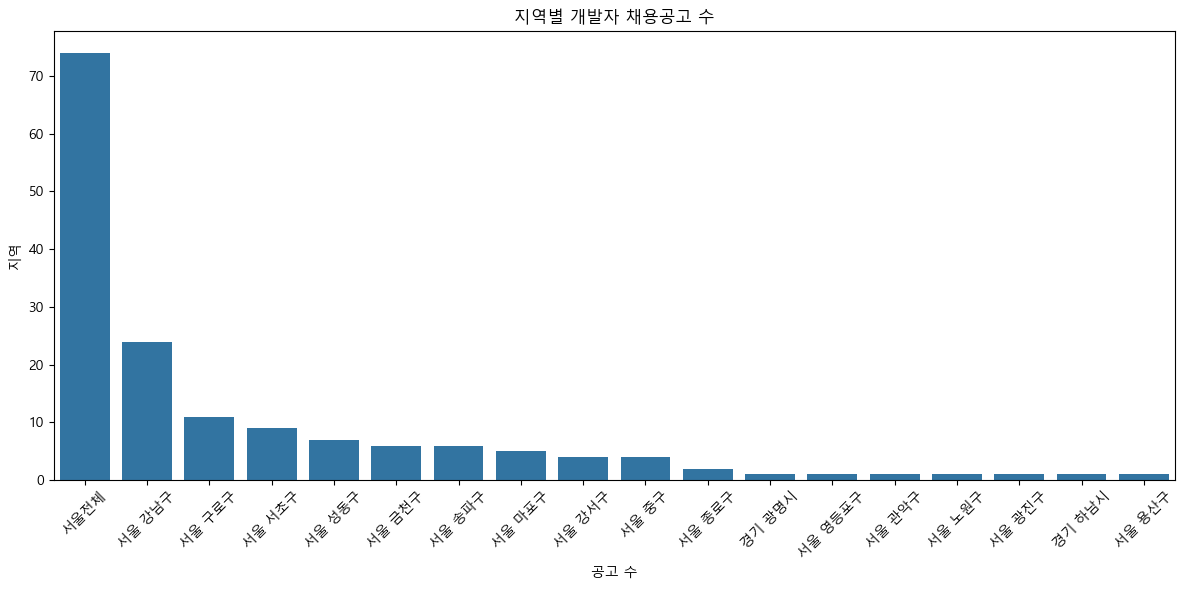

In [116]:

# 지역별 공고 수
plt.figure(figsize=(12, 6))
sns.countplot(data=dev_df, x='지역', order=dev_df['지역'].value_counts().index)
plt.title('지역별 개발자 채용공고 수')
plt.xlabel('공고 수')
plt.ylabel('지역')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

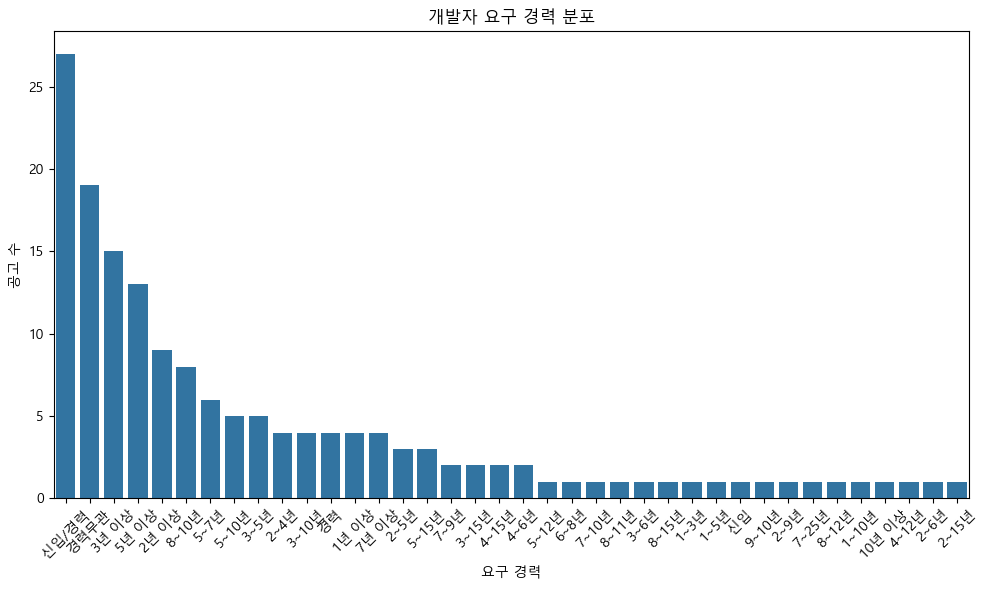

In [117]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dev_df, x='요구경력', order=dev_df['요구경력'].value_counts().index)
plt.title('개발자 요구 경력 분포')
plt.xlabel('요구 경력')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

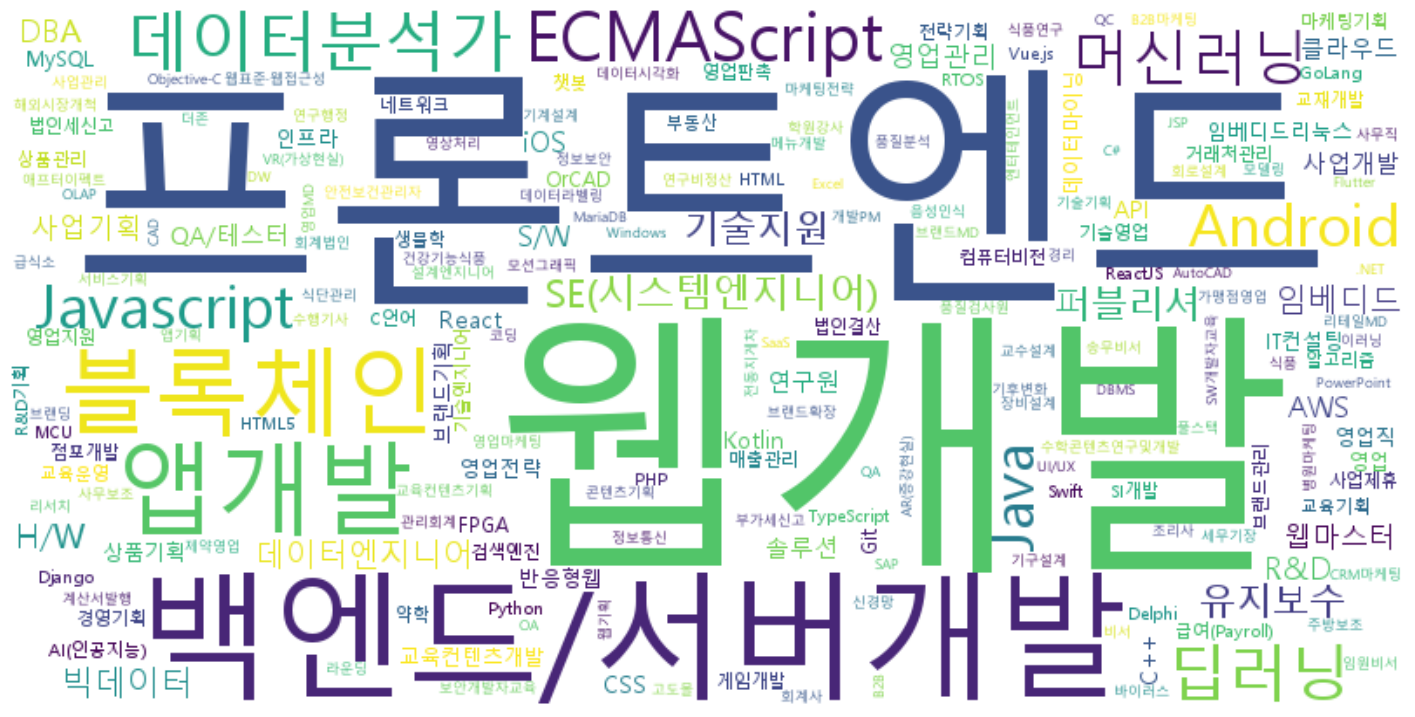

In [142]:
from wordcloud import WordCloud
df_exploded = dev_df.explode('직무')
job_counts = df_exploded['직무'].value_counts()

wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(job_counts.to_dict())

plt.figure(figsize=(18, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()